In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

## Preparación de datos

In [3]:
# Ruta del archivo CSV
#ruta_csv = "0_dataset_training.csv"  # Asegúrate que esté en el mismo directorio o cambia el path
ruta_csv = "combined_df.csv" 

# Cargar el dataset
df = pd.read_csv(ruta_csv)

# Visualizar columnas disponibles (opcional)
print("Columnas del archivo:")
print(df.columns.tolist())

Columnas del archivo:
['Well', 'Depth', 'Clay', 'Quartz', 'Carbonates', 'TOC', 'Formation', 'Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density', 'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens', 'Jun_classif', 'Jun_unified', 'Jun_classif_classes', 'Jun_unified_classes', 'TOC_class', 'well_number', 'Well Number']


In [4]:
df.drop(columns=['Clay', 'Carbonates', 'Jun_classif', 'Jun_unified', 'Jun_classif_classes',
       'Jun_unified_classes', 'TOC_class', 'well_number'], inplace=True)

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Evita divisiones por cero
df['NeutronPorosity'].replace(0, 1e-6, inplace=True)
df['Density'].replace(0, 1e-6, inplace=True)
df['Sonic'].replace(0, 1e-6, inplace=True)

# 2. Sonic - NeutronPorosity
df['Sonic_NP_Diff'] = df['Sonic'] - df['NeutronPorosity']
df['Sonic_NP_AbsDiff'] = np.abs(df['Sonic_NP_Diff'])

# 3. Sonic × Density
df['Sonic_Density_Product'] = df['Sonic'] * df['Density']

# 4. Inverso del producto (puede resaltar diferencias)
df['Inv_Sonic_Density'] = 1 / df['Sonic_Density_Product']

# 5. Photoelectric - valor de referencia para cuarzo (~1.81)
df['PE_Departure_Quartz'] = df['Photoelectric'] - 1.81

# 6. Clean Sand Index (combinación GR bajo y Densidad alta)
df['CleanSandIndex'] = (1 - df['GammaRay'] / df['GammaRay'].max()) * (df['Density'] / df['Density'].max())

# 7. Resistivity / NeutronPorosity (tipo relación de Archie)
df['ArchieRatio'] = df['Resistivity'] / df['NeutronPorosity']

# 8. Rolling statistics (ventana de 5 muestras)
window_size = 5
for col in ['Sonic', 'Density', 'GammaRay']:
    df[f'{col}_roll_mean'] = df[col].rolling(window=window_size, center=True, min_periods=1).mean()
    df[f'{col}_roll_std'] = df[col].rolling(window=window_size, center=True, min_periods=1).std().fillna(0)

print("✅ Características calculadas añadidas exitosamente a df.")

✅ Características calculadas añadidas exitosamente a df.


In [6]:
# Seleccionar curvas de entrada relevantes (con sentido geológico/petrofísico)
curvas_input = ['Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density', 'Photoelectric',
    'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens']


curvas_calculated = [
    # Calculadas
    'Sonic_NP_Diff',
    'Sonic_NP_AbsDiff',
    'Sonic_Density_Product',
    'Inv_Sonic_Density',
    'PE_Departure_Quartz',
    'CleanSandIndex',
    'ArchieRatio',
    'Sonic_roll_mean',
    'Sonic_roll_std',
    'Density_roll_mean',
    'Density_roll_std',
    'GammaRay_roll_mean',
    'GammaRay_roll_std']

# Variable objetivo
target = 'Quartz'

In [7]:
# Crear DataFrame con solo las variables necesarias
df_modelo = df[curvas_input + curvas_calculated + [target]].copy()

# Mostrar las primeras filas
df_modelo.head()

,Sonic,GammaRay,NeutronPorosity,Resistivity,Density,Photoelectric,AvgPorosity,RHOMAA,UMA,GR_Dens,...,PE_Departure_Quartz,CleanSandIndex,ArchieRatio,Sonic_roll_mean,Sonic_roll_std,Density_roll_mean,Density_roll_std,GammaRay_roll_mean,GammaRay_roll_std,Quartz
0,80.00674,61.79465,0.24560,21.25296,2.59795,5.7005,0.200711,2.999215,18.402937,23.785927,...,3.8905,0.539767,86.534853,76.946997,2.700082,2.511983,0.074483,92.498950,26.640739,49.526372
1,74.89855,109.48310,0.25430,36.39704,2.46675,8.7508,0.226427,2.896073,27.757992,44.383541,...,6.9408,0.496760,143.126387,76.794510,2.225602,2.477475,0.091988,98.137612,24.501647,57.018752
2,75.93570,106.21910,0.25615,42.38375,2.47125,8.9295,0.227161,2.903694,28.406222,42.981932,...,7.1195,0.498746,165.464576,76.964548,1.964572,2.453530,0.095985,102.038730,22.942136,16.548721
3,76.33705,115.05360,0.28790,184.61350,2.37395,7.7611,0.265648,2.870970,24.908553,48.465048,...,5.9511,0.476301,641.241749,76.456840,1.134467,2.405210,0.058663,106.470150,13.367235,17.577069
4,77.64470,117.64320,0.18490,51.75293,2.35775,7.9863,0.191456,2.679253,23.170002,49.896384,...,6.1763,0.472234,279.896862,77.727332,2.099590,2.413470,0.071086,115.486870,25.555948,43.132829


In [8]:
# Eliminar filas con valores nulos
df_modelo.dropna(inplace=True)

# Separar entrada (X) y salida (y)
X = df_modelo[curvas_input].values
y = df_modelo[target].values.reshape(-1, 1)  # reshape para mantener dimensión 2D

# Normalizar X e y entre -1 y 1 (como en el paper)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [9]:
# Dividir aleatoriamente: 70% entrenamiento, 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42
)

# Confirmar tamaños
print(f"Tamaño entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño validación: {X_test.shape[0]} muestras")

Tamaño entrenamiento: 1186 muestras
Tamaño validación: 509 muestras


## Entrenamiento y evaluación ANN

In [10]:
# Definir modelo de red neuronal
modelo_ann = MLPRegressor(
    hidden_layer_sizes=(15,),       # Una capa con 15 neuronas
    activation='tanh',              # Función de activación como en el paper
    solver='adam',                  # Optimizador
    max_iter=1000,                  # Número máximo de iteraciones
    random_state=42
)

# Entrenar el modelo
modelo_ann.fit(X_train, y_train.ravel())  # y_train.ravel() para convertirlo a 1D

MLPRegressor(activation='tanh', hidden_layer_sizes=(15,), max_iter=1000,
             random_state=42)

In [11]:
# Predicción en datos de prueba
y_pred_scaled = modelo_ann.predict(X_test).reshape(-1, 1)

# Desescalar predicciones y datos reales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_real = scaler_y.inverse_transform(y_test)

# Métricas de evaluación
r2 = r2_score(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mae = mean_absolute_error(y_real, y_pred)

print(f"R²     : {r2:.4f}")
print(f"RMSE   : {rmse:.4f}")
print(f"MAE    : {mae:.4f}")

R²     : 0.2816
RMSE   : 19.2689
MAE    : 15.4460


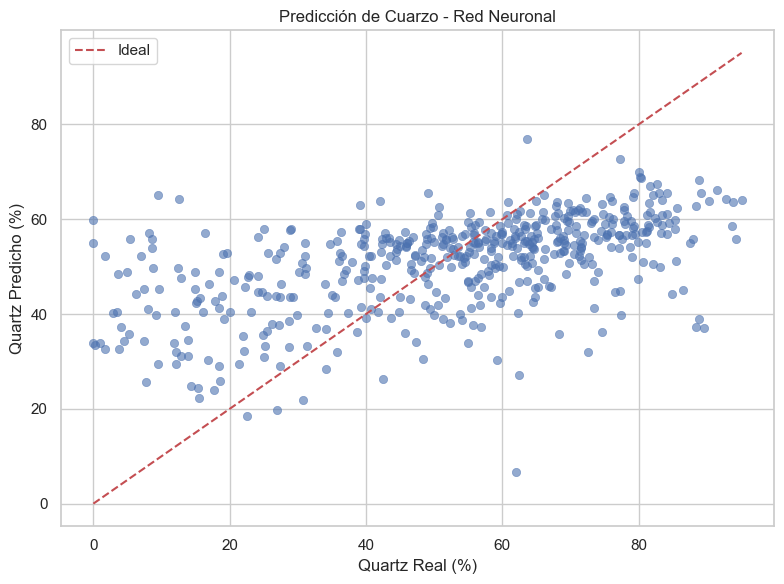

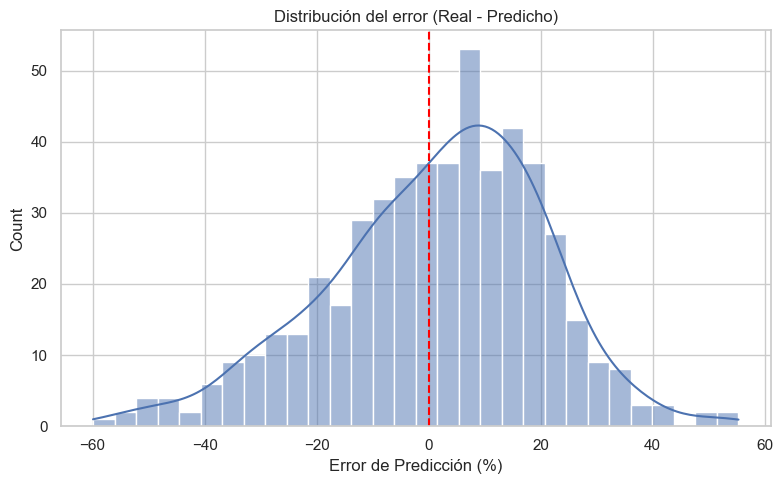

In [12]:
# Configurar estilo
sns.set(style="whitegrid")

# Scatter plot: Real vs Predicho
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_real.flatten(), y=y_pred.flatten(), alpha=0.6, edgecolor=None)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--', label='Ideal')
plt.xlabel("Quartz Real (%)")
plt.ylabel("Quartz Predicho (%)")
plt.title("Predicción de Cuarzo - Red Neuronal")
plt.legend()
plt.tight_layout()
plt.show()

# Histograma de errores (residuos)
errores = (y_real - y_pred).flatten()
plt.figure(figsize=(8, 5))
sns.histplot(errores, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribución del error (Real - Predicho)")
plt.xlabel("Error de Predicción (%)")
plt.tight_layout()
plt.show()

## Ajuste del modelo

In [13]:
from sklearn.model_selection import GridSearchCV

# Definir modelo base
mlp_base = MLPRegressor(max_iter=1000, solver='adam', random_state=42)

# Definir grid de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [
        (10,), (20,), (30,), 
        (20, 10), (30, 15), (40, 20),  # dos capas
        (30, 20, 10)  # tres capas (más complejidad)
    ],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.005, 0.01],  # regularización L2
    'learning_rate_init': [0.0005, 0.001, 0.005],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000]
}


# Configurar GridSearch con validación cruzada
grid_search = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Ejecutar búsqueda
grid_search.fit(X_train, y_train.ravel())

# Mejor modelo
mejor_modelo = grid_search.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Mejores hiperparámetros encontrados:
{'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (30, 20, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000}


In [14]:
# Predicción con el mejor modelo
y_pred_scaled_opt = mejor_modelo.predict(X_test).reshape(-1, 1)

# Desescalado
y_pred_opt = scaler_y.inverse_transform(y_pred_scaled_opt)
y_real_opt = scaler_y.inverse_transform(y_test)

# Métricas
r2_opt = r2_score(y_real_opt, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_real_opt, y_pred_opt))
mae_opt = mean_absolute_error(y_real_opt, y_pred_opt)

with np.errstate(divide='ignore', invalid='ignore'):
    aape_opt = np.mean(np.abs((y_real_opt - y_pred_opt) / np.where(y_real_opt == 0, np.nan, y_real_opt))) * 100

print(f"[Optimizado] R²     : {r2_opt:.4f}")
print(f"[Optimizado] RMSE   : {rmse_opt:.4f}")
print(f"[Optimizado] MAE    : {mae_opt:.4f}")
print(f"[Optimizado] AAPE % : {aape_opt:.2f}")

[Optimizado] R²     : 0.3597
[Optimizado] RMSE   : 18.1916
[Optimizado] MAE    : 13.9541
[Optimizado] AAPE % : nan


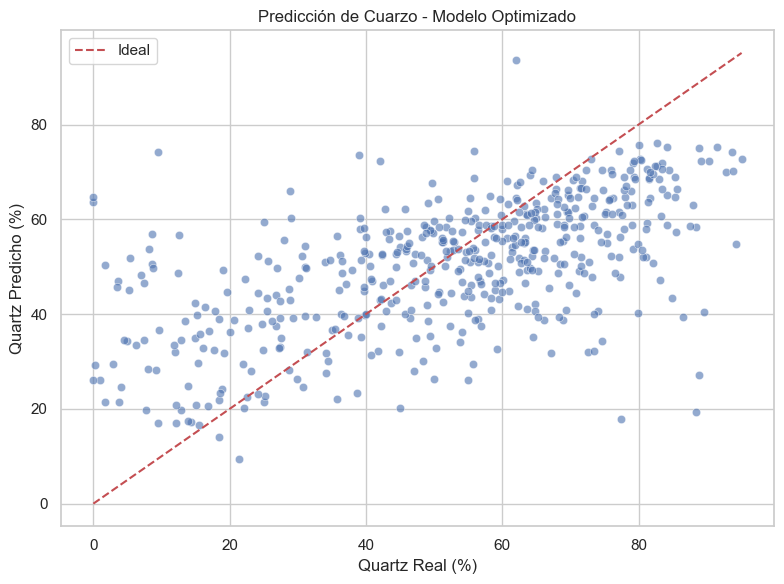

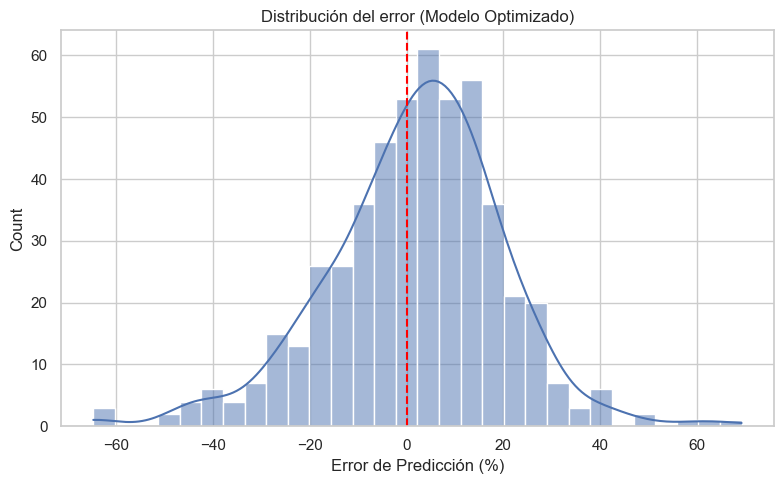

In [15]:
# Scatter: Real vs Predicho (modelo optimizado)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_real_opt.flatten(), y=y_pred_opt.flatten(), alpha=0.6)
plt.plot([y_real_opt.min(), y_real_opt.max()], [y_real_opt.min(), y_real_opt.max()], 'r--', label='Ideal')
plt.xlabel("Quartz Real (%)")
plt.ylabel("Quartz Predicho (%)")
plt.title("Predicción de Cuarzo - Modelo Optimizado")
plt.legend()
plt.tight_layout()
plt.show()

# Histograma de errores
errores_opt = (y_real_opt - y_pred_opt).flatten()
plt.figure(figsize=(8, 5))
sns.histplot(errores_opt, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribución del error (Modelo Optimizado)")
plt.xlabel("Error de Predicción (%)")
plt.tight_layout()
plt.show()

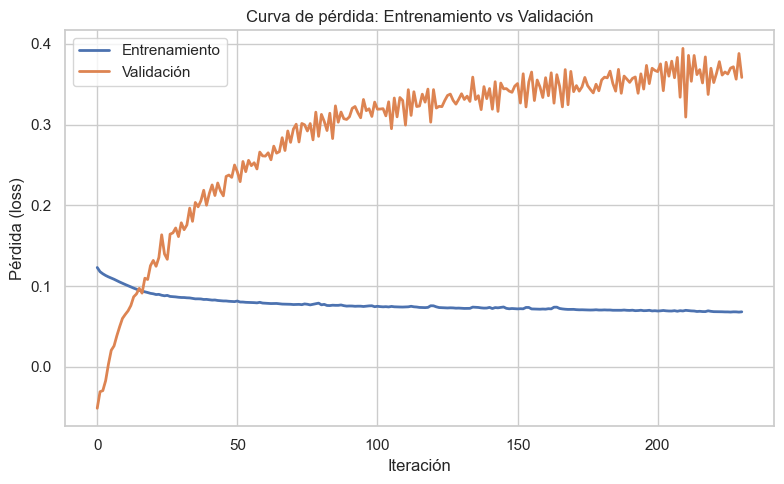

In [16]:
# Redefinimos el modelo final con validación interna
modelo_con_validacion = MLPRegressor(
    hidden_layer_sizes=mejor_modelo.hidden_layer_sizes,
    activation=mejor_modelo.activation,
    alpha=mejor_modelo.alpha,
    learning_rate_init=mejor_modelo.learning_rate_init,
    learning_rate=mejor_modelo.learning_rate,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42
)

# Entrenamiento
modelo_con_validacion.fit(X_train, y_train.ravel())

plt.figure(figsize=(8, 5))
plt.plot(modelo_con_validacion.loss_curve_, label='Entrenamiento', linewidth=2)
plt.plot(modelo_con_validacion.validation_scores_, label='Validación', linewidth=2)
plt.title("Curva de pérdida: Entrenamiento vs Validación")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Balanceo del *target*

Cuantiles de Quartz:
 0.10    16.449065
0.25    33.955065
0.50    55.000000
0.75    69.393892
0.90    79.926631
Name: Quartz, dtype: float64


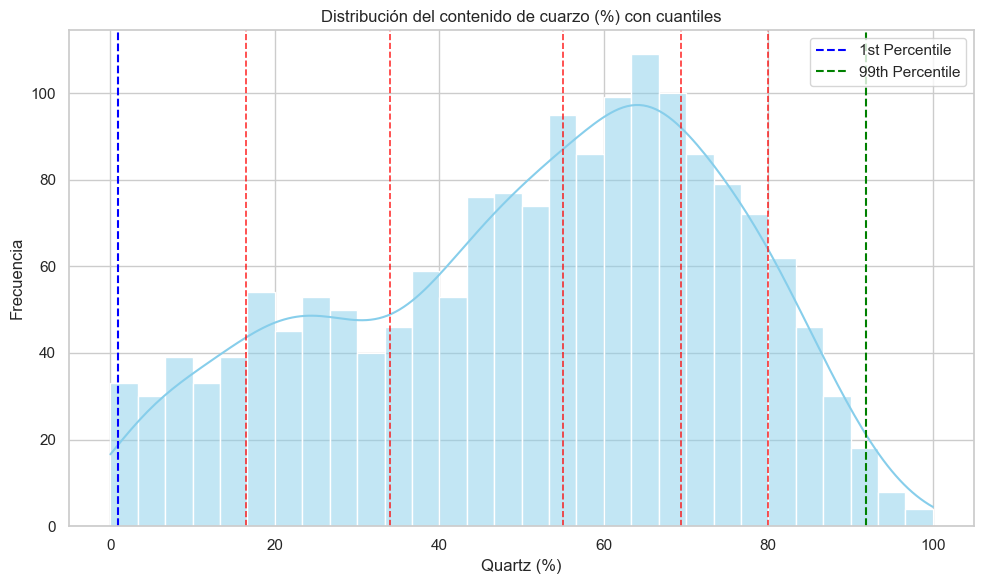

In [17]:
# Calcular cuantiles clave
quantiles = df_modelo['Quartz'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
print("Cuantiles de Quartz:\n", quantiles)

# Graficar histograma con KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_modelo['Quartz'], bins=30, kde=True, color='skyblue')

# Dibujar líneas verticales para cada cuantil
for q in quantiles:
    plt.axvline(x=q, color='red', linestyle='--', linewidth=1.2, alpha=0.8)

# Etiquetas y título
plt.title("Distribución del contenido de cuarzo (%) con cuantiles")
plt.xlabel("Quartz (%)")
plt.ylabel("Frecuencia")
plt.grid(True)

plt.axvline(df_modelo['Quartz'].quantile(0.01), color='blue', linestyle='--', label='1st Percentile')
plt.axvline(df_modelo['Quartz'].quantile(0.99), color='green', linestyle='--', label='99th Percentile')
#leyenda a la derecha
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
# Crear subconjuntos
df_bajo = df_modelo[df_modelo['Quartz'] < 30].copy()
df_medio = df_modelo[(df_modelo['Quartz'] >= 30) & (df_modelo['Quartz'] <= 70)].copy()
df_alto = df_modelo[df_modelo['Quartz'] > 70].copy()

# Ver cuántos registros hay por grupo
print("Tamaño de cada subconjunto:")
print(f"✔️ Cuarzo bajo  : {df_bajo.shape[0]} muestras")
print(f"✔️ Cuarzo medio : {df_medio.shape[0]} muestras")
print(f"✔️ Cuarzo alto  : {df_alto.shape[0]} muestras")

Tamaño de cada subconjunto:
✔️ Cuarzo bajo  : 376 muestras
✔️ Cuarzo medio : 914 muestras
✔️ Cuarzo alto  : 405 muestras


### Segmento Cuarzo bajo (< 30%)

In [19]:
# Seleccionar X e y
X_bajo = df_bajo.drop(columns=['Quartz']).values
y_bajo = df_bajo['Quartz'].values.reshape(-1, 1)

# Normalizar entre -1 y 1
scaler_X_bajo = MinMaxScaler(feature_range=(-1, 1))
scaler_y_bajo = MinMaxScaler(feature_range=(-1, 1))

X_bajo_scaled = scaler_X_bajo.fit_transform(X_bajo)
y_bajo_scaled = scaler_y_bajo.fit_transform(y_bajo)

# División 70/30
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bajo_scaled, y_bajo_scaled, test_size=0.2, random_state=42
)

# Confirmar tamaños
print(f"Tamaño entrenamiento (cuarzo bajo): {Xb_train.shape[0]} muestras")
print(f"Tamaño validación  (cuarzo bajo): {Xb_test.shape[0]} muestras")

Tamaño entrenamiento (cuarzo bajo): 300 muestras
Tamaño validación  (cuarzo bajo): 76 muestras


In [20]:
# ---------------------------
# BLOQUE 18.2: GRID SEARCH - MODELO CUARZO BAJO
# ---------------------------

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo base
modelo_base_bajo = MLPRegressor(solver='adam', early_stopping=True, validation_fraction=0.1, n_iter_no_change=15, max_iter=1000, random_state=42)

# Definir grilla de búsqueda conservadora
param_grid_bajo = {
    'hidden_layer_sizes': [
        (10,), (20,), (30,), 
        (20, 10), (30, 15), (40, 20),  # dos capas
        (30, 20, 10)  # tres capas (más complejidad)
    ],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.001, 0.005, 0.01],  # regularización L2
    'learning_rate_init': [0.0005, 0.001, 0.005],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000]
}

# Ejecutar GridSearch con 5-fold cross-validation
grid_bajo = GridSearchCV(
    estimator=modelo_base_bajo,
    param_grid=param_grid_bajo,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Ajustar a los datos
grid_bajo.fit(Xb_train, yb_train.ravel())

# Guardar el mejor modelo
modelo_bajo_optimo = grid_bajo.best_estimator_
print("\nMejores hiperparámetros (cuarzo bajo):")
print(grid_bajo.best_params_)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits

Mejores hiperparámetros (cuarzo bajo):
{'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (30, 15), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000}


[CUARZO BAJO] R²     : 0.1432
[CUARZO BAJO] RMSE   : 7.2800
[CUARZO BAJO] MAE    : 5.8270
[CUARZO BAJO] AAPE % : nan


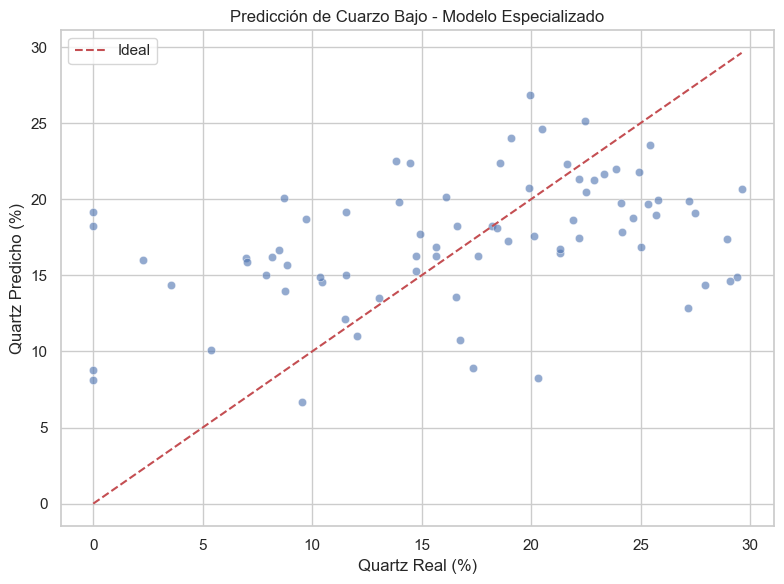

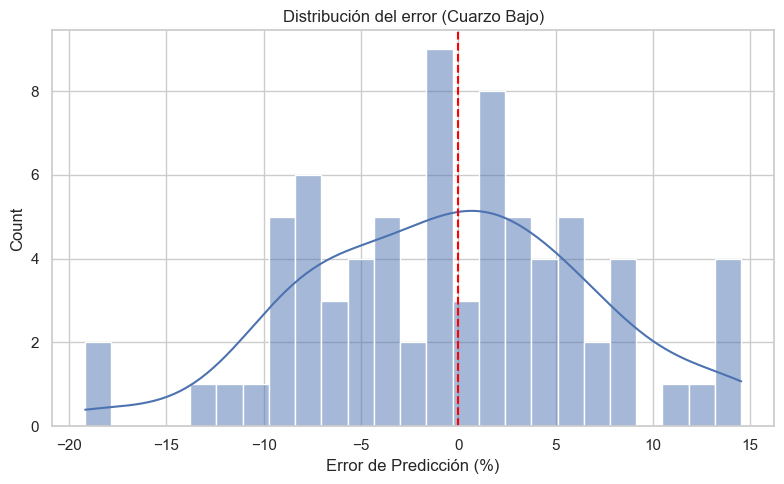

In [21]:
# ---------------------------
# BLOQUE 18.3: EVALUACIÓN Y VISUALIZACIÓN - CUARZO BAJO
# ---------------------------

# Predicción
yb_pred_scaled = modelo_bajo_optimo.predict(Xb_test).reshape(-1, 1)

# Desnormalización
yb_pred = scaler_y_bajo.inverse_transform(yb_pred_scaled)
yb_real = scaler_y_bajo.inverse_transform(yb_test)

# Métricas
r2_bajo = r2_score(yb_real, yb_pred)
rmse_bajo = np.sqrt(mean_squared_error(yb_real, yb_pred))
mae_bajo = mean_absolute_error(yb_real, yb_pred)

with np.errstate(divide='ignore', invalid='ignore'):
    aape_bajo = np.mean(np.abs((yb_real - yb_pred) / np.where(yb_real == 0, np.nan, yb_real))) * 100

# Mostrar resultados
print(f"[CUARZO BAJO] R²     : {r2_bajo:.4f}")
print(f"[CUARZO BAJO] RMSE   : {rmse_bajo:.4f}")
print(f"[CUARZO BAJO] MAE    : {mae_bajo:.4f}")
print(f"[CUARZO BAJO] AAPE % : {aape_bajo:.2f}")

# Visualización: Real vs Predicho
plt.figure(figsize=(8, 6))
sns.scatterplot(x=yb_real.flatten(), y=yb_pred.flatten(), alpha=0.6)
plt.plot([yb_real.min(), yb_real.max()], [yb_real.min(), yb_real.max()], 'r--', label='Ideal')
plt.xlabel("Quartz Real (%)")
plt.ylabel("Quartz Predicho (%)")
plt.title("Predicción de Cuarzo Bajo - Modelo Especializado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograma de errores
errores_bajo = (yb_real - yb_pred).flatten()
plt.figure(figsize=(8, 5))
sns.histplot(errores_bajo, bins=25, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribución del error (Cuarzo Bajo)")
plt.xlabel("Error de Predicción (%)")
plt.tight_layout()
plt.show()

### Cuarzo medio (30% - 70%)

In [22]:
# ---------------------------
# BLOQUE 19.1: PREPROCESAMIENTO - CUARZO MEDIO
# ---------------------------

# Seleccionar X e y
X_medio = df_medio.drop(columns=['Quartz']).values
y_medio = df_medio['Quartz'].values.reshape(-1, 1)

# Normalizar entre -1 y 1
scaler_X_medio = MinMaxScaler(feature_range=(-1, 1))
scaler_y_medio = MinMaxScaler(feature_range=(-1, 1))

X_medio_scaled = scaler_X_medio.fit_transform(X_medio)
y_medio_scaled = scaler_y_medio.fit_transform(y_medio)

# División 70/30
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_medio_scaled, y_medio_scaled, test_size=0.3, random_state=42
)

# Confirmar tamaños
print(f"Tamaño entrenamiento (cuarzo medio): {Xm_train.shape[0]}")
print(f"Tamaño validación    (cuarzo medio): {Xm_test.shape[0]}")

Tamaño entrenamiento (cuarzo medio): 639
Tamaño validación    (cuarzo medio): 275


In [23]:
# ---------------------------
# BLOQUE 19.2: GRID SEARCH - MODELO CUARZO MEDIO
# ---------------------------

# Modelo base con validación interna
modelo_base_medio = MLPRegressor(
    solver='adam',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=15,
    max_iter=1000,
    random_state=42
)

# Grilla de hiperparámetros ampliada
param_grid_medio = {
    'hidden_layer_sizes': [
        (10,), (20,), (30,),
        (30, 15), (40, 20), (30, 20, 10)
    ],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0005, 0.001, 0.005, 0.01],
    'learning_rate_init': [0.001, 0.005],
    'learning_rate': ['constant', 'adaptive']
}

# GridSearchCV
grid_medio = GridSearchCV(
    estimator=modelo_base_medio,
    param_grid=param_grid_medio,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Entrenamiento
grid_medio.fit(Xm_train, ym_train.ravel())

# Guardar mejor modelo
modelo_medio_optimo = grid_medio.best_estimator_
print("\nMejores hiperparámetros (cuarzo medio):")
print(grid_medio.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits

Mejores hiperparámetros (cuarzo medio):
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (30, 15), 'learning_rate': 'constant', 'learning_rate_init': 0.001}


[CUARZO MEDIO] R²     : -0.0338
[CUARZO MEDIO] RMSE   : 11.2515
[CUARZO MEDIO] MAE    : 9.1885
[CUARZO MEDIO] AAPE % : 19.31


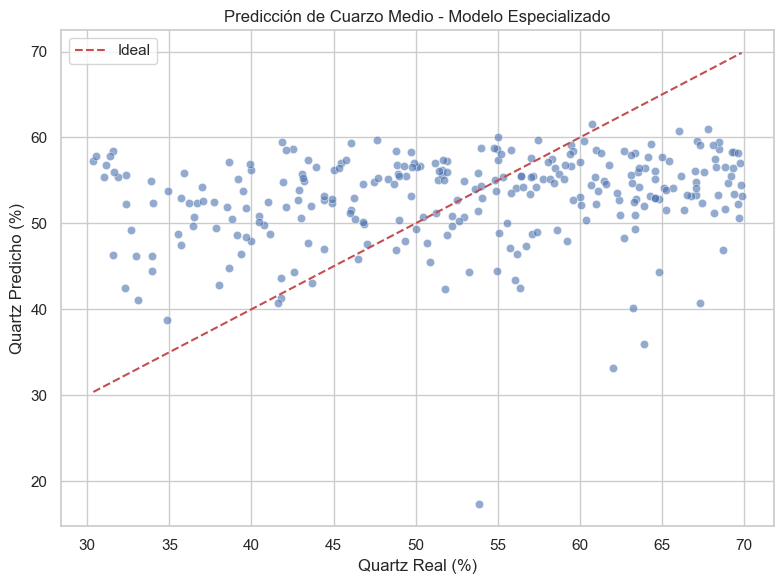

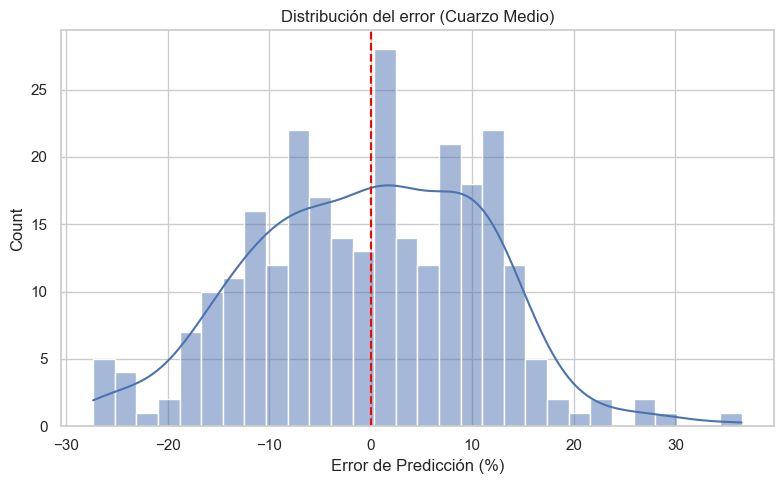

In [24]:
# ---------------------------
# BLOQUE 19.3: EVALUACIÓN Y VISUALIZACIÓN - CUARZO MEDIO
# ---------------------------

# Predicción
ym_pred_scaled = modelo_medio_optimo.predict(Xm_test).reshape(-1, 1)

# Desnormalización
ym_pred = scaler_y_medio.inverse_transform(ym_pred_scaled)
ym_real = scaler_y_medio.inverse_transform(ym_test)

# Métricas
r2_medio = r2_score(ym_real, ym_pred)
rmse_medio = np.sqrt(mean_squared_error(ym_real, ym_pred))
mae_medio = mean_absolute_error(ym_real, ym_pred)

with np.errstate(divide='ignore', invalid='ignore'):
    aape_medio = np.mean(np.abs((ym_real - ym_pred) / np.where(ym_real == 0, np.nan, ym_real))) * 100

print(f"[CUARZO MEDIO] R²     : {r2_medio:.4f}")
print(f"[CUARZO MEDIO] RMSE   : {rmse_medio:.4f}")
print(f"[CUARZO MEDIO] MAE    : {mae_medio:.4f}")
print(f"[CUARZO MEDIO] AAPE % : {aape_medio:.2f}")

# Visualización: Real vs Predicho
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ym_real.flatten(), y=ym_pred.flatten(), alpha=0.6)
plt.plot([ym_real.min(), ym_real.max()], [ym_real.min(), ym_real.max()], 'r--', label='Ideal')
plt.xlabel("Quartz Real (%)")
plt.ylabel("Quartz Predicho (%)")
plt.title("Predicción de Cuarzo Medio - Modelo Especializado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograma de errores
errores_medio = (ym_real - ym_pred).flatten()
plt.figure(figsize=(8, 5))
sns.histplot(errores_medio, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribución del error (Cuarzo Medio)")
plt.xlabel("Error de Predicción (%)")
plt.tight_layout()
plt.show()